In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker
from scipy.stats import t
import math

In [2]:
data = pd.read_csv("./asos_cust_prod_network_experiment.csv")

# Calculate the overall runtime = time spent in CT + GA + CA
data['overall_runtime'] = \
    data['CT_runtime'] + data['GA_runtime'] + data['CA_runtime']

In [3]:
# Calculate statistics for each network and for each number of threads 
# tested
grouped_data = \
    data[data['num_threads'] == 64] \
        .groupby(['num_communities', 'parallelised']) \
        .agg({
            "num_communities": ['count'],
            "GA_runtime": ['mean', 'std'],
            "CA_runtime": ['mean', 'std'],
            "overall_runtime": ['mean', 'std']
        })
        
# Compressing the column levels and rename some volumes to more
# sensible headings
grouped_data.columns = \
    grouped_data.columns.get_level_values(0) + "_" + \
    grouped_data.columns.get_level_values(1)
    
grouped_data = \
    grouped_data \
        .reset_index()\
        .rename(columns={'num_communities_count':'num_samples'})
        
# Calculate the 95% CI width x (i.e. the 95% CI will be [-x, x]) 
# based on the std dev. and sample size
def calculate_95_CI_pos_val(stdev, n):
    return stdev / np.sqrt(n) * t.ppf(0.95, n-1)

grouped_data['GA_runtime_95_CI'] = \
    grouped_data.apply(
        lambda x: calculate_95_CI_pos_val(x['GA_runtime_std'], 
                                          x['num_samples']),
        axis=1)

grouped_data['CA_runtime_95_CI'] = \
    grouped_data.apply(
        lambda x: calculate_95_CI_pos_val(x['CA_runtime_std'], 
                                          x['num_samples']),
        axis=1)
    
grouped_data['overall_runtime_95_CI'] = \
    grouped_data.apply(
        lambda x: calculate_95_CI_pos_val(x['overall_runtime_std'], 
                                          x['num_samples']),
        axis=1)

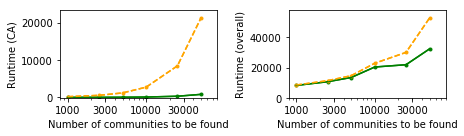

In [4]:
plt.clf()
fig = plt.figure(figsize=(6.5, 2))

stages = ['CA', 'overall']

for stage in stages:
        
    ax = fig.add_subplot(1, len(stages), stages.index(stage) + 1)
    
    for parallelised in [True, False]:

        # The actual runtime (with parallelisation) from experiments
        ax.plot(grouped_data[grouped_data['parallelised'] == parallelised]
                            ['num_communities'], 
                grouped_data[grouped_data['parallelised'] == parallelised]
                            [stage + '_runtime_mean'],
                color=('green' if parallelised else 'orange'), 
                ls=('-' if parallelised else '--'), 
                marker = '.')
        
        # The error bar on the actual runtime
        ax.errorbar(grouped_data[grouped_data['parallelised'] == parallelised]
                                ['num_communities'], 
                    grouped_data[grouped_data['parallelised'] == parallelised]
                                [stage + '_runtime_mean'], 
                    grouped_data[grouped_data['parallelised'] == parallelised]
                                [stage + '_runtime_95_CI'],
                    color=('green' if parallelised else 'orange'),
                    ls=('-' if parallelised else '--'))

        ax.set_xscale('log')
        ax.set_xlim(800, 80000)
        ax.set_xticks([1000, 3000, 10000, 30000])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#       Leave some padding on both ends of the y-axis, but not too much
        ylim_low = -100 if np.min(grouped_data[stage + '_runtime_mean']) < 100 else 0
        ylim_high = np.max(grouped_data[stage + '_runtime_mean']) * 1.1
        
        ax.set_ylim(ylim_low, ylim_high)

        ax.set_xlabel('Number of communities to be found')
        ax.set_ylabel('Runtime (' + stage + ')')
        
plt.tight_layout()
        
plt.show()
# plt.savefig("./figures/asos_cust_prod_network_expt.pdf",
#             bbox_inches='tight', transparent=True)
